# Wave Speed Measurement

[Marcus (1984b)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/simulation-of-taylorcouette-flow-part-2-numerical-results-for-wavyvortex-flow-with-one-travelling-wave/10E30B9438EE61B3AA6EECA03F20D6AE) gives *angular* wave speeds for $m_1$ non-axisymmetric wavy-vortex flow, and claims that they are a very sensitive diagnostic of numerical calculations. 


## Measurement technique
In order to test our Dedalus equations against those, I've come up with a simple way to measure the wave speed. Because these are laminar flows, I simply insert a "probe" into the flow at a given point,  

$$\mathbf{v_{probe}} = \left(R_1 + \frac{1}{2}\right)\ \hat{\mathbf{r}} + 0.\ \hat{\mathbf{\theta}} + \frac{L_z}{2}\ \hat{\mathbf{z}}$$.

This records a time series of $w(\mathbf{v_{probe}})$. Below, I FFT that time series and extract the frequency corresponding to the peak power. 

## Table of Values
Values from [Marcus (1984b)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/simulation-of-taylorcouette-flow-part-2-numerical-results-for-wavyvortex-flow-with-one-travelling-wave/10E30B9438EE61B3AA6EECA03F20D6AE) or Willis 2002 (PhD thesis)

|$Re$ | $Re/Re_c$ | $\eta$ | $L_z$ | $m_1$ |$s_1/\Omega_1$ ($s_1$ raw units) | reference | 
|:--------|:-------|:-------|:----| :---|:---|:---|
| 243.81| 2.063 | 0.875 | 3 | 6 | $0.3757$ (0.05367) | M84b p. | 
| 458.098 | 3.98 | 0.868 | 2.4 | 6 | $0.3443 \pm 0.0001 $ | M84a p.61 | 
| 458.098 | 3.98 | 0.868 | 3. | 6 | $0.3344 \pm 0.0001 $ | M84a p.61 | 
| 687.147 | 5.97 | 0.868 | 2.2 | 6 | $0.3370 \pm 0.0001 $ | M84a p.61 | 


In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import dedalus.public as de
import h5py
import scipy.signal as sig
import scipy.interpolate as interp

In [2]:
datafile = "../scratch/TC_run_re2.44e+02_mu0.00e+00_eta8.75e-01_Lz3.00e+00_filter5.00e-01_nr64_ntheta64_nz64/time_series.h5"

In [3]:
data = h5py.File(datafile, "r")

In [4]:
t = data['scales/sim_time'][:]
w_probe = data['tasks/w_probe'][:,0,0,0]

In [5]:
eta = 0.875
omega1 = 1/eta - 1.
period = 2*np.pi/omega1

In [6]:
list(data['tasks'].keys())

['KE', 'Re_rms', 'enstrophy', 'u_rms', 'v_rms', 'w_probe', 'w_rms']

<IPython.core.display.Javascript object>


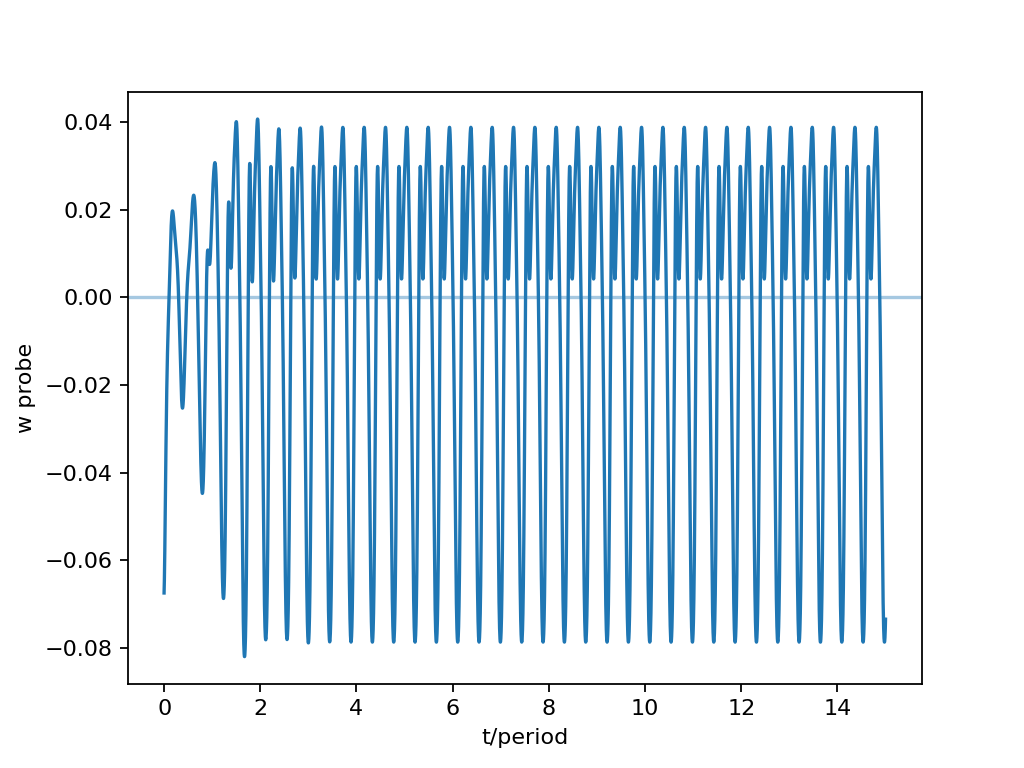

Text(0,0.5,'w probe')

In [7]:
plt.figure()
plt.plot(t/period, w_probe)
plt.axhline(0,alpha=0.4)
plt.xlabel('t/period')
plt.ylabel('w probe')

In [8]:
window = (t/period > 3)
n_samples = len(w_probe[window])

Notice that despite specifying a fixed `sim_dt` in the analysis task, the time steps are not quite even. The horizontal lines on the dt vs step plot are $1/160$ and $1/2000$, the limits Marcus (1984a) give for his wave speed tests. We can see that we're well within that range, and our actual timesteps are smaller than this, since these are just the output cadence $dt$.

In [9]:
dt = t[1] - t[0]

<IPython.core.display.Javascript object>


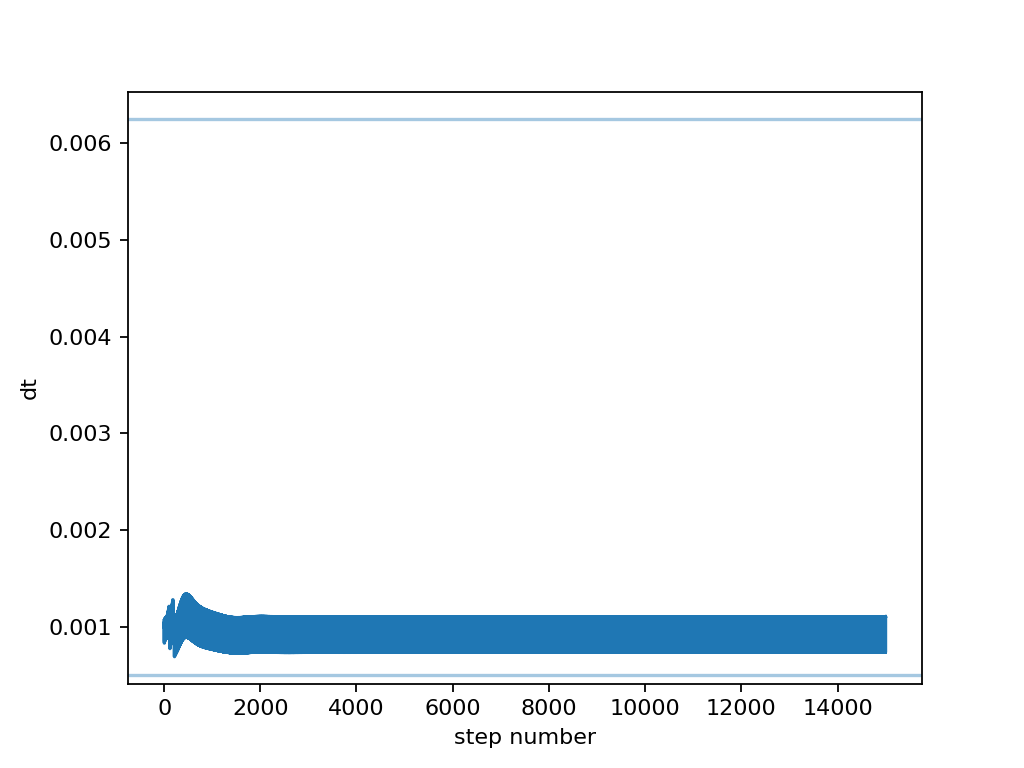

Text(0,0.5,'dt')

In [10]:
plt.figure()
plt.plot((t[1:]-t[0:-1])/period)
plt.axhline(1/160,alpha=0.4)
plt.axhline(1/2000,alpha=0.4)
plt.xlabel('step number')
plt.ylabel('dt')

I grabbed a representative simulation dt from the timeseries; it looks like we're writing out roughly every three timesteps (which is why the simulation took so long!)

In [11]:
sim_dt =  1.619062e-02

In [12]:
print("dt = {}".format(dt))
print("dt/sim_dt = {}".format(dt/sim_dt))

dt = 0.04675
dt/sim_dt = 2.887474352433693


Because of the irregular dt, we need to interpolate to a uniform grid in time.

In [13]:
dt_avg = (t[-1] - t[0])/len(w_probe)

In [14]:
t_grid = np.arange(len(w_probe))*dt_avg
wpp_interp = interp.griddata(t, w_probe, t_grid)

I now take the FFT with a Bartlett window (picked pretty much at random). This doesn't really matter, since we can clearly pick out the peak frequency anyway.

From the FFT, compute the power spectrum

In [15]:
w = sig.bartlett(n_samples)

In [16]:
wph_interp = np.fft.rfft(wpp_interp[window]*w)
freq_interp = np.fft.rfftfreq(n_samples,d=dt_avg)
df = freq_interp[1] - freq_interp[0]
wpp_interp = (wph_interp*wph_interp.conj()).real

Now, compute angular wave speeds, 

$$s = \omega/m,$$

being careful to note that scipy/numpy FFT return the linear frequency $f$, not $\omega = 2 \pi f$.

In [17]:
r1 = eta/(1- eta)
rp = r1 + 0.5
m = 6

wave_freq= 2*np.pi*freq_interp[wpp_interp == wpp_interp.max()][0]
s =  wave_freq/m

s_uncert = 2*np.pi*df/m

s_marcus = 0.05367
freq_marcus = s_marcus * m/(2*np.pi)

<IPython.core.display.Javascript object>


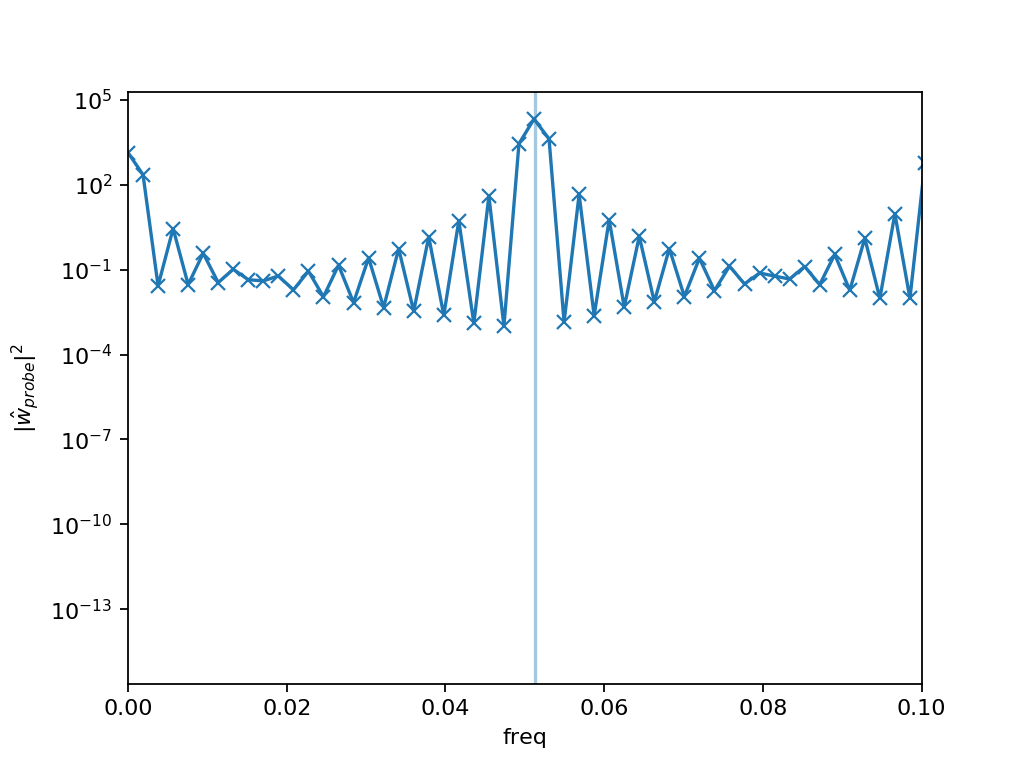

Text(0,0.5,'$|\\hat{w}_{probe}|^2$')

In [18]:
plt.figure()
plt.semilogy(freq_interp, wpp_interp,'x-')
plt.axvline(freq_marcus,alpha=0.4)
plt.xlim(0,0.1)
plt.xlabel('freq')
plt.ylabel(r'$|\hat{w}_{probe}|^2$')

In [19]:
print("Wave speed = {:4.3f} +/- {:4.3f}".format(s, s_uncert))

print("Marcus wave speed = {:7.5f}".format(s_marcus))
print("Uncertainty is {:4.2f} percent of wave speed".format(s_uncert/s*100))
print("Error in wave speed: {:4.1f} percent".format(100*(s-s_marcus)/s_marcus))

Wave speed = 0.054 +/- 0.002
Marcus wave speed = 0.05367
Uncertainty is 3.70 percent of wave speed
Error in wave speed: -0.2 percent
